In [14]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
import copy

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(dataset_name='UCIHAR')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6213, 561]),
 torch.Size([1554, 561]),
 torch.Size([6213]),
 torch.Size([1554]))

In [3]:
X_test = X_test[:1000]
y_test = y_test[:1000]

100%|██████████| 30/30 [01:12<00:00,  2.41s/it]


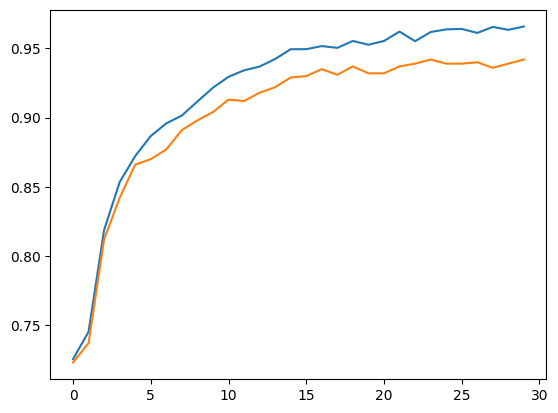

0.9658780097961426 0.9419999718666077


In [4]:
D = 4000
acc_history, test_acc_history = [], []
model = onlinehd.OnlineHD(classes, features, dim=D)
best_model = None
for _ in tqdm.tqdm(range(30)):
  model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=1, one_pass_fit=False)
  
  yhat_train = model(X_train)
  yhat_test = model(X_test)

  acc = (y_train == yhat_train).float().mean().item()
  acc_test = (y_test == yhat_test).float().mean().item()

  if best_model is None or max(test_acc_history) < acc_test:
    best_model = copy.deepcopy(model)

  acc_history.append(acc)
  test_acc_history.append(acc_test)
model = best_model

plt.plot(acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.show()
print(max(acc_history), max(test_acc_history))

In [5]:
with open('./onlinehd_ucihar.pickle', 'bw') as f:
    pickle.dump(model, f)

In [6]:
with open('./onlinehd_ucihar.pickle', 'br') as f:
    model = pickle.load(f)

In [7]:
model_dnn = DNNmodels.NeuralNetwork(num_classes=classes, flatten_layer=False, input_dim=features)
model_dnn.load_state_dict(torch.load('./model_dnn_ucihar.pt'))
model_dnn.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=561, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=12, bias=True)
  )
)

## Kernel based attack

In [8]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [00:31<00:00, 32.12it/s]


31.709696054458618
0.01 0.0094200000166893 0.8539999723434448 0.9010000228881836


100%|██████████| 1000/1000 [00:30<00:00, 32.70it/s]


31.14510989189148
0.020000000000000004 0.0188400000333786 0.7319999933242798 0.8529999852180481


100%|██████████| 1000/1000 [00:30<00:00, 32.68it/s]


31.159756183624268
0.030000000000000006 0.02826000191271305 0.6010000109672546 0.7590000033378601


100%|██████████| 1000/1000 [00:30<00:00, 32.44it/s]


31.430179119110107
0.04000000000000001 0.037679996341466904 0.49799999594688416 0.6710000038146973


100%|██████████| 1000/1000 [00:32<00:00, 30.35it/s]


33.48972010612488
0.05000000000000001 0.0471000038087368 0.4189999997615814 0.5920000076293945


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


32.853959798812866
0.06000000000000001 0.0565200038254261 0.3409999907016754 0.5149999856948853


100%|██████████| 1000/1000 [00:32<00:00, 30.76it/s]


33.177159786224365
0.07 0.0659399926662445 0.2770000100135803 0.45899999141693115


100%|██████████| 1000/1000 [00:32<00:00, 30.91it/s]


33.03206205368042
0.08 0.07535999268293381 0.19699999690055847 0.3869999945163727


100%|██████████| 1000/1000 [00:32<00:00, 30.98it/s]


32.95170497894287
0.09000000000000001 0.0847800150513649 0.1379999965429306 0.31299999356269836


100%|██████████| 1000/1000 [00:32<00:00, 30.98it/s]


32.96279716491699
0.1 0.0942000076174736 0.09600000083446503 0.26899999380111694


## FGSM

### Normlized

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu', 
    input_dim=features, model_type='dnn')

100%|██████████| 1000/1000 [00:04<00:00, 226.15it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 4.42569908400003 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 94.20%
mean of norm=0.010000024922192097


100%|██████████| 1000/1000 [00:04<00:00, 229.08it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 4.3734342500000025 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 93.50%
mean of norm=0.019999990239739418


100%|██████████| 1000/1000 [00:04<00:00, 221.03it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 4.532613499999968 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 93.50%
mean of norm=0.030000019818544388


100%|██████████| 1000/1000 [00:04<00:00, 228.71it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 4.380340750000016 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 93.10%
mean of norm=0.03999997302889824


100%|██████████| 1000/1000 [00:04<00:00, 222.55it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 4.501685874999964 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 92.50%
mean of norm=0.05000000447034836


100%|██████████| 1000/1000 [00:04<00:00, 226.73it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 4.419075375000034 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 91.30%
mean of norm=0.0599999763071537


100%|██████████| 1000/1000 [00:04<00:00, 226.19it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 4.429356417000008 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 90.00%
mean of norm=0.07000003010034561


100%|██████████| 1000/1000 [00:04<00:00, 227.36it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 4.40725170799999 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 89.10%
mean of norm=0.07999996095895767


100%|██████████| 1000/1000 [00:04<00:00, 226.28it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 4.427449249999995 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 87.40%
mean of norm=0.09000003337860107


100%|██████████| 1000/1000 [00:04<00:00, 225.49it/s]


FGSM Attack with epsilon = 0.10000 | Elapsed time: 4.442937625000013 seconds.
Accuracy: Before the attack -> 94.20%	|	After the attack -> 84.60%
mean of norm=0.09999995678663254


In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, dnn_attacked_acc)

0.01 0.010000024922192097 0.9419999718666077 0.9440000057220459
0.020000000000000004 0.019999990239739418 0.9350000023841858 0.9440000057220459
0.030000000000000006 0.030000019818544388 0.9350000023841858 0.9440000057220459
0.04000000000000001 0.03999997302889824 0.9309999942779541 0.9440000057220459
0.05000000000000001 0.05000000447034836 0.925000011920929 0.9430000185966492
0.06000000000000001 0.0599999763071537 0.9129999876022339 0.9430000185966492
0.07 0.07000003010034561 0.8999999761581421 0.9440000057220459
0.08 0.07999996095895767 0.890999972820282 0.9430000185966492
0.09000000000000001 0.09000003337860107 0.8740000128746033 0.9399999976158142
0.1 0.09999995678663254 0.8460000157356262 0.9369999766349792


## Deep Fool

In [15]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, features)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], features)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update, num_classes=classes, input_dim=features, model_type='dnn')
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s]


149.38920974731445
0.01 0.006396553944796324 0.8830000162124634 0.9120000004768372


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


134.6188521385193
0.02 0.012793106958270073 0.777999997138977 0.8759999871253967


100%|██████████| 1000/1000 [01:55<00:00,  8.68it/s]


115.18753409385681
0.03 0.019189661368727684 0.6489999890327454 0.7919999957084656


100%|██████████| 1000/1000 [01:37<00:00, 10.29it/s]


97.16080904006958
0.04 0.025586213916540146 0.5400000214576721 0.7070000171661377


100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


94.70178890228271
0.05 0.031982772052288055 0.4490000009536743 0.6330000162124634


100%|██████████| 1000/1000 [01:22<00:00, 12.05it/s]


82.96551704406738
0.060000000000000005 0.038379326462745667 0.4050000011920929 0.574999988079071


100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s]


76.15751075744629
0.06999999999999999 0.04477587714791298 0.3840000033378601 0.5329999923706055


100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s]


74.8591639995575
0.08 0.05117242783308029 0.37599998712539673 0.5070000290870667


100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


78.13739895820618
0.09 0.0575689971446991 0.37599998712539673 0.4699999988079071


100%|██████████| 1000/1000 [01:09<00:00, 14.34it/s]


69.71756911277771
0.09999999999999999 0.06396554410457611 0.37599998712539673 0.45500001311302185


100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


68.16982793807983
0.11 0.07036210596561432 0.37599998712539673 0.43799999356269836


100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s]


68.09378790855408
0.12 0.07675865292549133 0.37599998712539673 0.4180000126361847


100%|██████████| 1000/1000 [01:03<00:00, 15.80it/s]


63.302685260772705
0.13 0.08315521478652954 0.37599998712539673 0.40400001406669617


100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


58.381579637527466
0.14 0.08955175429582596 0.37599998712539673 0.3930000066757202


100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


66.9007978439331
0.15000000000000002 0.09594830870628357 0.37599998712539673 0.38499999046325684


100%|██████████| 1000/1000 [01:03<00:00, 15.65it/s]


63.891263008117676
0.16 0.10234485566616058 0.37599998712539673 0.3799999952316284


100%|██████████| 1000/1000 [01:06<00:00, 15.00it/s]


66.65371203422546
0.17 0.10874141752719879 0.37599998712539673 0.3779999911785126


100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


60.75166201591492
0.18000000000000002 0.1151379868388176 0.375 0.37400001287460327


100%|██████████| 1000/1000 [01:01<00:00, 16.22it/s]


61.64823508262634
0.19 0.12153454124927521 0.375 0.37299999594688416


100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]


60.54725933074951
0.2 0.12793110311031342 0.375 0.36800000071525574


In [16]:
X_te_cln = X_test.clone().reshape(-1, 1, features)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], features)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None, num_classes=classes, input_dim=features, model_type='dnn')

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, features))
yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, dnn_attacked_acc)

100%|██████████| 1000/1000 [01:00<00:00, 16.53it/s]


None 0.05622242018580437 0.37599998712539673 0.45399999618530273


## Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0001, 0.0015, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, features))
    yhat_test_dnn = model_dnn(X_test_noised.reshape(-1, features)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    dnn_attacked_acc = (y_test == yhat_test_dnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, features) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, dnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


100%|██████████| 1000/1000 [1:28:48<00:00,  5.33s/it]


5328.54657793045
0.0001 0.024670787155628204 0.9380000233650208 0.9399999976158142
Alpha : 0.0001736842105263158


100%|██████████| 1000/1000 [1:27:47<00:00,  5.27s/it]


5267.119422912598
0.0001736842105263158 0.042688723653554916 0.9409999847412109 0.9399999976158142
Alpha : 0.0002473684210526316


100%|██████████| 1000/1000 [1:27:28<00:00,  5.25s/it]


5248.944002151489
0.0002473684210526316 0.06039124354720116 0.9350000023841858 0.9419999718666077
Alpha : 0.00032105263157894735


100%|██████████| 1000/1000 [1:27:21<00:00,  5.24s/it]


5241.701611995697
0.00032105263157894735 0.07688301801681519 0.9340000152587891 0.9309999942779541
Alpha : 0.00039473684210526315


100%|██████████| 1000/1000 [1:27:34<00:00,  5.25s/it]


5254.287860155106
0.00039473684210526315 0.09471023082733154 0.9210000038146973 0.9369999766349792
Alpha : 0.00046842105263157895


100%|██████████| 1000/1000 [1:27:24<00:00,  5.24s/it]


5244.258899927139
0.00046842105263157895 0.10947924107313156 0.9190000295639038 0.9330000281333923
Alpha : 0.0005421052631578948


100%|██████████| 1000/1000 [1:28:02<00:00,  5.28s/it]


5282.360844135284
0.0005421052631578948 0.11621851474046707 0.9169999957084656 0.9319999814033508
Alpha : 0.0006157894736842106


100%|██████████| 1000/1000 [1:29:28<00:00,  5.37s/it]


5368.861949920654
0.0006157894736842106 0.12219490110874176 0.9190000295639038 0.9309999942779541
Alpha : 0.0006894736842105264


100%|██████████| 1000/1000 [1:29:55<00:00,  5.40s/it]


5395.880470991135
0.0006894736842105264 0.12328942865133286 0.9129999876022339 0.9300000071525574
Alpha : 0.0007631578947368421


100%|██████████| 1000/1000 [1:31:03<00:00,  5.46s/it]


5463.557543992996
0.0007631578947368421 0.12320497632026672 0.9240000247955322 0.9279999732971191
Alpha : 0.000836842105263158


100%|██████████| 1000/1000 [1:29:51<00:00,  5.39s/it]


5391.20790719986
0.000836842105263158 0.12515570223331451 0.9120000004768372 0.9309999942779541
Alpha : 0.0009105263157894737


100%|██████████| 1000/1000 [1:33:27<00:00,  5.61s/it]


5607.633490085602
0.0009105263157894737 0.12539024651050568 0.9079999923706055 0.9330000281333923
Alpha : 0.0009842105263157895


100%|██████████| 1000/1000 [1:31:29<00:00,  5.49s/it]


5489.393592119217
0.0009842105263157895 0.1262480467557907 0.9139999747276306 0.9319999814033508
Alpha : 0.0010578947368421053


100%|██████████| 1000/1000 [1:38:55<00:00,  5.94s/it]


5935.324522018433
0.0010578947368421053 0.12747260928153992 0.9129999876022339 0.9269999861717224
Alpha : 0.0011315789473684212


100%|██████████| 1000/1000 [1:35:50<00:00,  5.75s/it]


5750.95636677742
0.0011315789473684212 0.1274508833885193 0.9079999923706055 0.9279999732971191
Alpha : 0.0012052631578947368


100%|██████████| 1000/1000 [1:45:50<00:00,  6.35s/it]


6350.87061882019
0.0012052631578947368 0.1284582018852234 0.9139999747276306 0.9240000247955322
Alpha : 0.0012789473684210527


100%|██████████| 1000/1000 [1:37:48<00:00,  5.87s/it]


5868.787466049194
0.0012789473684210527 0.12787781655788422 0.9190000295639038 0.9290000200271606
Alpha : 0.0013526315789473685


100%|██████████| 1000/1000 [1:35:43<00:00,  5.74s/it]


5743.73579287529
0.0013526315789473685 0.12964607775211334 0.9110000133514404 0.9259999990463257
Alpha : 0.0014263157894736842


100%|██████████| 1000/1000 [1:35:16<00:00,  5.72s/it]


5716.768394947052
0.0014263157894736842 0.13010554015636444 0.906000018119812 0.9340000152587891
Alpha : 0.0015


100%|██████████| 1000/1000 [1:36:32<00:00,  5.79s/it]


5792.304743051529
0.0015 0.13057146966457367 0.9100000262260437 0.9340000152587891
